In [0]:
!pip3 -qq install torch==0.4.1
!pip -qq install torchtext==0.3.1
!pip install msgpack==0.5.6
!pip -qq install spacy==2.0.18
!pip -qq install torchvision==0.2.1
!python -m spacy download en
!pip install sacremoses==0.0.5
!pip install subword_nmt==0.3.5
!wget -qq http://www.manythings.org/anki/rus-eng.zip 
!unzip rus-eng.zip

tcmalloc: large alloc 1073750016 bytes == 0x58f9e000 @  0x7f1f90b832a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 317kB 19.7MB/s 
spacy 2.0.18 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
  Found existing installation: msgpack 0.6.0
    Uninstalling msgpack-0.6.0:
      Successfully uninstalled msgpack-0.6.0
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
cufflinks 0.14.6 has requirement plotly>=3.0.0, but you'll have plotly 1.12.12 which is incompatible.
    100% |████████████████████████████████| 37.4MB 48.0MB/s 
  Running setup.py install for en-core-web-sm ... - \ | done

    Linking successful
    /usr/local/lib/pyth

In [0]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
    DEVICE = torch.device('cuda')
else:
    from torch import FloatTensor, LongTensor
    DEVICE = torch.device('cpu')

np.random.seed(42)

# Attention

В прошлый раз мы реализовали простую Seq2seq модель:

![](https://raw.githubusercontent.com/tensorflow/nmt/master/nmt/g3doc/img/seq2seq.jpg =x400)  
*From [tensorflow/nmt](https://github.com/tensorflow/nmt)*

Основной её недостаток - вся информация об исходном тексте кодируется в единственный вектор фиксированного размера. Но очевидно же, что идея эта так себе.

Давайте запоминать все скрытые состояния энкодера, а не только последнее.

Дальше, для вычисления нового слова при генерации найдем сначала представление уже сгенерированного контекста (по которому обычно и генерируется следующее слово).  
По этому представлению посчитаем оценки полезности состояний энкодера: `attention weights` на картинке ниже. Чем выше вес - тем более полезно состояние. (Можно, кстати, представлять, что в предыдущем варианте мы просто давали всем состояниям кроме последнего вес 0, а последнему - 1).

С этими весами состояния энкодера суммируются, и мы получаем взвешенный вектор-представление контекста. Опять вектор?! Но теперь этот вектор получен для конкретного генерируемого слова - это же гораздо лучше, чем пытаться сделать один вектор сразу для всех генерируемых слов.

![attention](https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg =x400)  
From [Neural Machine Translation (seq2seq) Tutorial](https://www.tensorflow.org/tutorials/seq2seq).

Более наглядно это может быть в [динамике](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/attention_mechanism.gif) (из cs224n + shad nlp course).

В результате получаются такие красивые картинки с визуализацией аттеншена:   
![att-vis](https://www.tensorflow.org/images/seq2seq/attention_vis.jpg =x500)

Яркость ячейки показывает насколько много внимания уделяла модель данному слову на исходном языке при генерации соответствующего ему слова.

Очень красивая статья с демонстрацией attention'а: [Attention and Augmented Recurrent Neural Networks](https://distill.pub/2016/augmented-rnns/).

## Подготовка

Возьмем те же данные, что и в прошлый раз:

In [0]:
!shuf -n 10 rus.txt

You need a joystick.	Тебе нужен джойстик.
Tom may leave anytime he wants to.	Том может уходить когда хочет.
You have to take care of Tom.	Ты должна позаботиться о Томе.
Don't you have any money?	У тебя нет денег?
I'm glad you didn't get injured.	Я рад, что ты не пострадал.
I'd tell you the same thing.	Я бы вам то же самое сказал.
Tom is busy right now.	Прямо сейчас Том занят.
Tom, can you hear me?	Том, тебе меня слышно?
Tom didn't call 911.	Том не звонил в 911.
She thinks of nothing but making money.	Она думает только о зарабатывании денег.


Токенизируем их:

In [0]:
from torchtext.data import Field, Example, Dataset, BucketIterator

BOS_TOKEN = '<s>'
EOS_TOKEN = '</s>'

source_field = Field(tokenize='spacy', init_token=None, eos_token=EOS_TOKEN, lower=True)
target_field = Field(tokenize='moses', init_token=BOS_TOKEN, eos_token=EOS_TOKEN, lower=True)
fields = [('source', source_field), ('target', target_field)]

In [0]:
from tqdm import tqdm

MAX_TOKENS_COUNT = 16
SUBSET_SIZE = .3

examples = []
with open('rus.txt') as f:
    for line in tqdm(f, total=328190):
        source_text, target_text = line.split('\t')
        source_text = source_field.preprocess(source_text)
        target_text = target_field.preprocess(target_text)
        if len(source_text) <= MAX_TOKENS_COUNT and len(target_text) <= MAX_TOKENS_COUNT:
            if np.random.rand() < SUBSET_SIZE:
                examples.append(Example.fromlist([source_text, target_text], fields))

100%|██████████| 328190/328190 [00:56<00:00, 5859.43it/s]


Построим датасеты:

In [0]:
dataset = Dataset(examples, fields)

train_dataset, test_dataset = dataset.split(split_ratio=0.85)

print('Train size =', len(train_dataset))
print('Test size =', len(test_dataset))

source_field.build_vocab(train_dataset, min_freq=2)
print('Source vocab size =', len(source_field.vocab))

target_field.build_vocab(train_dataset, min_freq=2)
print('Target vocab size =', len(target_field.vocab))

train_iter, test_iter = BucketIterator.splits(
    datasets=(train_dataset, test_dataset), batch_sizes=(32, 512), shuffle=True, device=DEVICE, sort=False
)

Train size = 83261
Test size = 14693
Source vocab size = 6296
Target vocab size = 14073


## Seq2seq модель

Старая модель выглядела так:

In [0]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, rnn_hidden_dim=256, num_layers=1, bidirectional=False):
        super().__init__()

        self._emb = nn.Embedding(vocab_size, emb_dim)
        self._rnn = nn.GRU(input_size=emb_dim, hidden_size=rnn_hidden_dim, 
                           num_layers=num_layers, bidirectional=bidirectional)

    def forward(self, inputs, hidden=None):
        encoder_output, encoder_hidden = self._rnn(self._emb(inputs), hidden)
        return encoder_output, encoder_hidden

In [0]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, rnn_hidden_dim=256, attn_dim=128, num_layers=1):
        super().__init__()

        self._emb = nn.Embedding(vocab_size, emb_dim)
        self._attention = MultiplicativeAttention(rnn_hidden_dim, rnn_hidden_dim, attn_dim)
        self._rnn = nn.GRU(input_size=emb_dim + rnn_hidden_dim, 
                           hidden_size=rnn_hidden_dim, num_layers=num_layers)
        self._out = nn.Linear(rnn_hidden_dim, vocab_size)

    def forward(self, inputs, encoder_output, encoder_mask, hidden=None):
        embs = self._emb(inputs)
        outputs, attentions = [], []
        key_proj = self._attention._key_layer(encoder_output)
        for i in range(embs.shape[0]):
            # encoder_output (seq_len, batch_size, rnn_hidden_dim)
            # hidden (1, batch_size, rnn_hidden_dim)
            context, f_att = self._attention(query=hidden, key_proj=key_proj, 
                                             value=encoder_output, mask=encoder_mask)
            context = context.unsqueeze(0)
            rnn_input = torch.cat((embs[i: i+1], context), -1)
            output, hidden = self._rnn(rnn_input, hidden)
            
            outputs.append(output)
            attentions.append(f_att)
            
        output = torch.cat(outputs)
        attentions = torch.cat(attentions)
        return self._out(output), hidden, attentions

## Реализация attention'а

В общем случае, attention работает так: пусть у нас есть набор скрытых состояний $\mathbf{s}_1, \ldots, \mathbf{s}_m$ - представлений слов из исходного языка, полученных с помощью энкодера. И есть некоторое текущее скрытое состояние $\mathbf{h}_i$ - скажем, представление, используемое для предсказания слова на нужном нам языке.

Тогда с помощью аттеншена мы можем получить взвешенное представление контекста $\mathbf{s}_1, \ldots, \mathbf{s}_m$ - вектор $\mathbf{c}_i$:
$$
\begin{align}\begin{split}
\mathbf{c}_i &= \sum\limits_j a_{ij}\mathbf{s}_j\\
\mathbf{a}_{ij} &= \text{softmax}(f_{att}(\mathbf{h}_i, \mathbf{s}_j))
\end{split}\end{align}
$$

$f_{att}$ - функция, которая говорит, насколько хорошо $\mathbf{h}_i$ и $\mathbf{s}_j$ подходят друг другу.

Самые популярные её варианты:
- Additive attention:
$$f_{att}(\mathbf{h}_i, \mathbf{s}_j) = \mathbf{v}_a{}^\top \text{tanh}(\mathbf{W}_a\mathbf{h}_i + \mathbf{W}_b\mathbf{s}_j)$$
- Dot attention:
$$f_{att}(\mathbf{h}_i, \mathbf{s}_j) = \mathbf{h}_i^\top \mathbf{s}_j$$
- Multiplicative attention:
$$f_{att}(\mathbf{h}_i, \mathbf{s}_j) = \mathbf{h}_i^\top \mathbf{W}_a \mathbf{s}_j$$

**Задание** Реализуйте Additive attention.

In [0]:
class AdditiveAttention(nn.Module):
    def __init__(self, query_size, key_size, hidden_dim):
        super().__init__()
        
        self._query_layer = nn.Linear(query_size, hidden_dim)
        self._key_layer = nn.Linear(key_size, hidden_dim)
        self._energy_layer = nn.Linear(hidden_dim, 1)
        
    def forward(self, query, key_proj, value, mask):
        # key (seq_len, batch_size, rnn_hidden_dim)
        # query (1, batch_size, rnn_hidden_dim)
        query = self._query_layer(query)
        f_att = self._energy_layer(torch.tanh(query + key_proj))
        f_att.data.masked_fill_(mask.unsqueeze(2), -float('inf'))
        
        # f_att (seq_len, batch_size, 1)
        
        f_att = F.softmax(f_att, 0)
        
        scores = f_att * value
        
        return scores.sum(0), f_att

In [0]:
class DotAttention(nn.Module):
    def __init__(self, query_size, key_size, hidden_dim):  # query_size == hidden_dim, 
        # но пусть будет как отдельная переменная, чтобы не переписывать декодер
        super().__init__()
        
        self._key_layer = nn.Linear(key_size, hidden_dim)
        
    def forward(self, query, key_proj, value, mask):
        # key (seq_len, batch_size, rnn_hidden_dim)
        # query (1, batch_size, rnn_hidden_dim)
        
        query = query.permute(1, 2, 0)
        key_proj = key_proj.permute(1, 0, 2)
        f_att = query.new_zeros([key_proj.shape[0], key_proj.shape[1], query.shape[1]])  # (batch_size, seq_len, 1)
        for i in range(key_proj.shape[0]):
            f_att[i] = torch.matmul(key_proj[i], query[i])
        f_att = f_att.permute(1, 0, 2)
        
        f_att.data.masked_fill_(mask.unsqueeze(2), -float('inf'))
        
        # f_att (seq_len, batch_size, 1)
        
        f_att = F.softmax(f_att, 0)
        
        scores = f_att * value
        
        return scores.sum(0), f_att

In [0]:
class MultiplicativeAttention(nn.Module):
    def __init__(self, query_size, key_size, hidden_dim):
        super().__init__()
        
        self._query_layer = nn.Linear(query_size, hidden_dim)
        self._key_layer = nn.Linear(key_size, hidden_dim)
        
    def forward(self, query, key_proj, value, mask):
        # key (seq_len, batch_size, rnn_hidden_dim)
        # query (1, batch_size, rnn_hidden_dim)
        query = self._query_layer(query)
        
        query = query.permute(1, 2, 0)
        key_proj = key_proj.permute(1, 0, 2)
        f_att = query.new_zeros([key_proj.shape[0], key_proj.shape[1], query.shape[1]])  # (batch_size, seq_len, 1)
        for i in range(key_proj.shape[0]):
            f_att[i] = torch.matmul(key_proj[i], query[i])
        f_att = f_att.permute(1, 0, 2)
        
        f_att.data.masked_fill_(mask.unsqueeze(2), -float('inf'))
        
        # f_att (seq_len, batch_size, 1)
        
        f_att = F.softmax(f_att, 0)
        
        scores = f_att * value
        
        return scores.sum(0), f_att

Нужно обновить `Decoder`, чтобы он работал с attention'ом:  
![](https://image.ibb.co/fB12nq/2018-11-12-23-34-06.png =x500)  
*From [Attention and Augmented Recurrent Neural Networks](https://distill.pub/2016/augmented-rnns/#attentional-interfaces)*

На каждом шаге rnn'ки будем использовать текущее скрытое состояние декодера, чтобы определить, какие из состояний энкодера самые интересные.

Выход attention'а (текущий контекст) будем конкатенировать к эмбеддингу слова.

**Задание** Обновите `Decoder`.

In [0]:
batch = next(iter(train_iter))

Модель перевода будет просто сперва вызывать Encoder, а потом передавать его скрытое состояние декодеру в качестве начального.

In [0]:
class TranslationModel(nn.Module):
    def __init__(self, source_vocab_size, target_vocab_size, emb_dim=64, rnn_hidden_dim=128, 
                 attn_dim=128, num_layers=1, bidirectional_encoder=False):
        
        super().__init__()
        
        self.encoder = Encoder(source_vocab_size, emb_dim, rnn_hidden_dim, num_layers, bidirectional_encoder)
        self.decoder = Decoder(target_vocab_size, emb_dim, rnn_hidden_dim, attn_dim, num_layers)
        
    def forward(self, source_inputs, target_inputs):
        encoder_mask = source_inputs == 1
        encoder_output, encoder_hidden = self.encoder(source_inputs)
        
        return self.decoder(target_inputs, encoder_output, encoder_mask, encoder_hidden)

In [0]:
model = TranslationModel(source_vocab_size=len(source_field.vocab), target_vocab_size=len(target_field.vocab)).to(DEVICE)

model(batch.source, batch.target)[0].shape

torch.Size([17, 32, 14120])

## Тренировка модели

In [0]:
from nltk.translate.bleu_score import corpus_bleu

def evaluate_model(model, iterator):
    model.eval()
    refs, hyps = [], []
    bos_index = iterator.dataset.fields['target'].vocab.stoi[BOS_TOKEN]
    eos_index = iterator.dataset.fields['target'].vocab.stoi[EOS_TOKEN]
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            encoder_output, encoder_hidden = model.encoder(batch.source)
            mask = batch.source == 1.
            
            hidden = encoder_hidden
            result = [LongTensor([bos_index]).expand(1, batch.target.shape[1])]
            
            for _ in range(30):
                step, hidden, _ = model.decoder(result[-1], encoder_output, mask, hidden)
                step = step.argmax(-1)
                result.append(step)
            
            targets = batch.target.data.cpu().numpy().T
            eos_indices = (targets == eos_index).argmax(-1)
            eos_indices[eos_indices == 0] = targets.shape[1]

            targets = [target[:eos_ind] for eos_ind, target in zip(eos_indices, targets)]
            refs.extend(targets)
            
            result = torch.cat(result)
            result = result.data.cpu().numpy().T
            eos_indices = (result == eos_index).argmax(-1)
            eos_indices[eos_indices == 0] = result.shape[1]

            result = [res[:eos_ind] for eos_ind, res in zip(eos_indices, result)]
            hyps.extend(result)
            
    return corpus_bleu([[ref] for ref in refs], hyps) * 100

In [0]:
evaluate_model(model, test_iter)

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


42.467682589111234

In [0]:
import math
from tqdm import tqdm
tqdm.get_lock().locks = []


def do_epoch(model, criterion, data_iter, optimizer=None, name=None):
    epoch_loss = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = len(data_iter)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, batch in enumerate(data_iter):                
                logits, _, _ = model(batch.source, batch.target)
                
                target = torch.cat((batch.target[1:], batch.target.new_ones((1, batch.target.shape[1]))))
                loss = criterion(logits.view(-1, logits.shape[-1]), target.view(-1))

                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(), 1.)
                    optimizer.step()

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(name, loss.item(), 
                                                                                         math.exp(loss.item())))
                
            progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(
                name, epoch_loss / batches_count, math.exp(epoch_loss / batches_count))
            )
            progress_bar.refresh()

    return epoch_loss / batches_count


def fit(model, criterion, optimizer, train_iter, epochs_count=1, val_iter=None):
    best_val_loss = None
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss = do_epoch(model, criterion, train_iter, optimizer, name_prefix + 'Train:')
        
        if not val_iter is None:
            val_loss = do_epoch(model, criterion, val_iter, None, name_prefix + '  Val:')
            print('\nVal BLEU = {:.2f}'.format(evaluate_model(model, val_iter)))

In [0]:
model = TranslationModel(source_vocab_size=len(source_field.vocab), target_vocab_size=len(target_field.vocab)).to(DEVICE)

pad_idx = target_field.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).to(DEVICE)

optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_iter, epochs_count=11, val_iter=test_iter)

  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 20.02


[3 / 30] Train: Loss = 1.88807, PPX = 6.61:   0%|          | 1/2602 [00:00<08:01,  5.40it/s]


Val BLEU = 26.27


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 29.76


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 31.81


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 33.45


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 34.14


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 34.73


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 34.83


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 35.32


  0%|          | 1/2602 [00:00<08:30,  5.09it/s]


Val BLEU = 35.37


[11 / 30] Train: Loss = 0.64765, PPX = 1.91:   6%|▋         | 163/2602 [00:14<03:31, 11.53it/s]


KeyboardInterrupt: ignored

In [0]:
# dot attention
model = TranslationModel(source_vocab_size=len(source_field.vocab), target_vocab_size=len(target_field.vocab)).to(DEVICE)

pad_idx = target_field.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).to(DEVICE)

optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_iter, epochs_count=11, val_iter=test_iter)

  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 16.30


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 22.32


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 25.71


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 27.59


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 29.02


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 30.26


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 31.48


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 31.66


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 31.83


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 32.38


[11 / 11]   Val: Loss = 1.75908, PPX = 5.81: 100%|██████████| 29/29 [00:38<00:00,  1.32s/it]


KeyboardInterrupt: ignored

In [0]:
#multiplicative attention
model = TranslationModel(source_vocab_size=len(source_field.vocab), target_vocab_size=len(target_field.vocab)).to(DEVICE)

pad_idx = target_field.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).to(DEVICE)

optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_iter, epochs_count=11, val_iter=test_iter)

  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 15.85


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 21.07


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 23.71


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 25.71


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 27.20


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 27.82


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 28.66


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 29.11


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 29.39


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 29.89


[11 / 11]   Val: Loss = 1.85992, PPX = 6.42: 100%|██████████| 29/29 [00:38<00:00,  1.31s/it]



Val BLEU = 29.81


## Визуализация результатов

In [0]:
def greedy_decode(model, source_text, source_field, target_field):
    bos_index = target_field.vocab.stoi[BOS_TOKEN]
    eos_index = target_field.vocab.stoi[EOS_TOKEN]
    
    model.eval()
    with torch.no_grad():
        result, attentions = [], []
        source = source_field.preprocess(source_text)
        inputs = source_field.process([source]).to(DEVICE)
        
        encoder_output, encoder_hidden = model.encoder(inputs)
        encoder_mask = torch.zeros_like(inputs).byte()
        
        hidden = encoder_hidden
        step = LongTensor([[bos_index]])
        
        for _ in range(50):
            step, hidden, attention = model.decoder(step, encoder_output, encoder_mask, hidden)
            step = step.argmax(-1)
            attentions.append(attention.squeeze(1))
          
            if step.squeeze().item() == eos_index:
                break
            
            result.append(step.item())   
        result = [target_field.vocab.itos[ind] for ind in result]
        return source, result, torch.cat(attentions, -1).data.cpu().numpy()

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_heatmap(src, trg, scores):

    fig, ax = plt.subplots()
    heatmap = ax.pcolor(scores, cmap='viridis')

    ax.set_xticklabels(trg, minor=False, rotation=45)
    ax.set_yticklabels(src, minor=False)

    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(scores.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(scores.shape[0]) + 0.5, minor=False)
    ax.invert_yaxis()

    plt.colorbar(heatmap)
    plt.show()

In [0]:
source, result, attentions = greedy_decode(model, "He lied to me.", source_field, target_field)

In [0]:
result

['он', 'мне', 'соврал', '.']

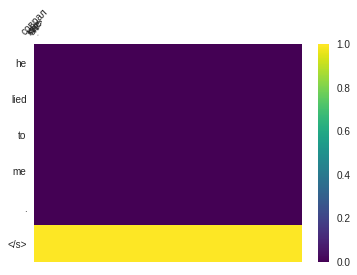

In [0]:
plot_heatmap(source + ['</s>'], ['<s>'] + result + ['</s>'], attentions)

## Улучшение модели

**Задание** Попробуйте другие варианты attention'а (из приведенных выше).

**Задание** Попробуйте приемы из тех, что были в предыдущем ноутбуке: bpe, dropout, bidirectional or multi-layer encoder.

In [0]:
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

with open('data.en', 'w') as f_src, open('data.ru', 'w') as f_dst:
    for example in examples:
        f_src.write(' '.join(example.source) + '\n')
        f_dst.write(' '.join(example.target) + '\n')

bpe = {}
for lang in ['en', 'ru']:
    with open('./data.' + lang) as f_data, open('bpe_rules.' + lang, 'w') as f_rules:
        learn_bpe(f_data, f_rules, num_symbols=3000)
    with open('bpe_rules.' + lang) as f_rules:
        bpe[lang] = BPE(f_rules)

In [0]:
from torchtext.data import Field, Example, Dataset, BucketIterator

BOS_TOKEN = '<s>'
EOS_TOKEN = '</s>'

source_field = Field(tokenize='spacy', init_token=None, eos_token=EOS_TOKEN)
target_field = Field(tokenize='moses', init_token=BOS_TOKEN, eos_token=EOS_TOKEN)
fields = [('source', source_field), ('target', target_field)]
source_field.preprocess(bpe['en'].process_line("It's surprising that you haven't heard anything about her wedding."))

['I@@',
 't@@',
 "'s",
 'surpri@@',
 'sing',
 'that',
 'you',
 'ha@@',
 've@@',
 "n't",
 'heard',
 'anything',
 'about',
 'her',
 'we@@',
 'd@@',
 'din@@',
 'g@@',
 '.']

In [0]:
from tqdm import tqdm

MAX_TOKENS_COUNT = 16
SUBSET_SIZE = .3

examples = []
with open('rus.txt') as f:
    for line in tqdm(f, total=328190):
        source_text, target_text = line.split('\t')
        source_text = bpe['en'].process_line(source_text)
        target_text = bpe['ru'].process_line(target_text)
        source_text = source_field.preprocess(source_text)
        target_text = target_field.preprocess(target_text)
        if len(source_text) <= MAX_TOKENS_COUNT and len(target_text) <= MAX_TOKENS_COUNT:
            if np.random.rand() < SUBSET_SIZE:
                examples.append(Example.fromlist([source_text, target_text], fields))

100%|██████████| 328190/328190 [03:15<00:00, 1680.12it/s]


In [0]:
dataset = Dataset(examples, fields)

train_dataset, test_dataset = dataset.split(split_ratio=0.85)

print('Train size =', len(train_dataset))
print('Test size =', len(test_dataset))

source_field.build_vocab(train_dataset, min_freq=3)
print('Source vocab size =', len(source_field.vocab))

target_field.build_vocab(train_dataset, min_freq=3)
print('Target vocab size =', len(target_field.vocab))

train_iter, test_iter = BucketIterator.splits(
    datasets=(train_dataset, test_dataset), batch_sizes=(32, 256), shuffle=True, device=DEVICE, sort=False
)

Train size = 22393
Test size = 3952
Source vocab size = 1881
Target vocab size = 2249


In [0]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, rnn_hidden_dim=256, num_layers=1, bidirectional=False):
        super().__init__()
        self.bidirectional = bidirectional
        self._emb = nn.Sequential(
            nn.Embedding(vocab_size, emb_dim),
            nn.Dropout(0.3)
        )
        self._rnn = nn.GRU(input_size=emb_dim, hidden_size=rnn_hidden_dim, 
                  num_layers=num_layers, bidirectional=bidirectional)

    def forward(self, inputs, hidden=None):
        encoder_output, encoder_hidden = self._rnn(self._emb(inputs), hidden)
        if self.bidirectional:
            encoder_hidden = torch.cat((encoder_hidden[0], encoder_hidden[1]), dim=-1).unsqueeze(0)
        return encoder_output, encoder_hidden
    
class AdditiveAttention(nn.Module):
    def __init__(self, query_size, key_size, hidden_dim):
        super().__init__()
        
        self._query_layer = nn.Linear(query_size, hidden_dim)
        self._key_layer = nn.Linear(key_size, hidden_dim)
        self._energy_layer = nn.Linear(hidden_dim, 1)
        
    def forward(self, query, key_proj, value, mask):
        # key (seq_len, batch_size, rnn_hidden_dim)
        # query (1, batch_size, rnn_hidden_dim)
        query = self._query_layer(query)
        f_att = self._energy_layer(torch.tanh(query + key_proj))
        f_att.data.masked_fill_(mask.unsqueeze(2), -float('inf'))
        
        # f_att (seq_len, batch_size, 1)
        f_att = F.softmax(f_att, 0)
        scores = f_att * value
        
        return scores.sum(0), f_att
    
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, rnn_hidden_dim=256, attn_dim=128, num_layers=1):
        super().__init__()

        self._emb = nn.Sequential(
            nn.Embedding(vocab_size, emb_dim),
            nn.Dropout(0.3)
        )
        self._attention = AdditiveAttention(rnn_hidden_dim, rnn_hidden_dim, attn_dim)
        self._rnn = nn.GRU(input_size=emb_dim + rnn_hidden_dim, 
                           hidden_size=rnn_hidden_dim, num_layers=num_layers)
        self._out = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(rnn_hidden_dim, vocab_size)
        )

    def forward(self, inputs, encoder_output, encoder_mask, hidden=None):
        embs = self._emb(inputs)
        outputs, attentions = [], []
        key_proj = self._attention._key_layer(encoder_output)
        for i in range(embs.shape[0]):
            # encoder_output (seq_len, batch_size, rnn_hidden_dim)
            # hidden (1, batch_size, rnn_hidden_dim)
            context, f_att = self._attention(query=hidden, key_proj=key_proj, 
                                             value=encoder_output, mask=encoder_mask)
            context = context.unsqueeze(0)
            rnn_input = torch.cat((embs[i: i+1], context), -1)
            output, hidden = self._rnn(rnn_input, hidden)
            
            outputs.append(output)
            attentions.append(f_att)
            
        output = torch.cat(outputs)
        attentions = torch.cat(attentions)
        return self._out(output), hidden, attentions
    
class ImprovedTranslationModel(nn.Module):
    def __init__(self, source_vocab_size, target_vocab_size, emb_dim=64, rnn_hidden_dim=128, 
                 attn_dim=128, num_layers=1, bidirectional_encoder=False):
        
        super().__init__()
        
        self.encoder = Encoder(source_vocab_size, emb_dim, rnn_hidden_dim, num_layers, bidirectional_encoder)
        self.decoder = Decoder(target_vocab_size, emb_dim, rnn_hidden_dim * (2 if bidirectional_encoder else 1), attn_dim, num_layers)
        
    def forward(self, source_inputs, target_inputs):
        encoder_mask = source_inputs == 1
        encoder_output, encoder_hidden = self.encoder(source_inputs)
        
        return self.decoder(target_inputs, encoder_output, encoder_mask, encoder_hidden)

In [0]:
batch = next(iter(train_iter))

In [0]:
model = ImprovedTranslationModel(source_vocab_size=len(source_field.vocab), target_vocab_size=len(target_field.vocab)).to(DEVICE)

model(batch.source, batch.target)[0].shape

torch.Size([18, 32, 2243])

In [0]:
dataset = Dataset(examples, fields)

train_dataset, test_dataset = dataset.split(split_ratio=0.85)

print('Train size =', len(train_dataset))
print('Test size =', len(test_dataset))

source_field.build_vocab(train_dataset, min_freq=3)
print('Source vocab size =', len(source_field.vocab))

target_field.build_vocab(train_dataset, min_freq=3)
print('Target vocab size =', len(target_field.vocab))

train_iter, test_iter = BucketIterator.splits(
    datasets=(train_dataset, test_dataset), batch_sizes=(32, 256), shuffle=True, device=DEVICE, sort=False
)

Train size = 22393
Test size = 3952
Source vocab size = 1881
Target vocab size = 2249


In [0]:
model = ImprovedTranslationModel(source_vocab_size=len(source_field.vocab), target_vocab_size=len(target_field.vocab)).to(DEVICE)

pad_idx = target_field.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).to(DEVICE)

optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_iter, epochs_count=30, val_iter=test_iter)

[2 / 30] Train: Loss = 1.97302, PPX = 7.19:   0%|          | 1/700 [00:00<01:33,  7.46it/s]


Val BLEU = 24.32


[3 / 30] Train: Loss = 1.84665, PPX = 6.34:   0%|          | 1/700 [00:00<01:29,  7.79it/s]


Val BLEU = 27.92


[4 / 30] Train: Loss = 1.76239, PPX = 5.83:   0%|          | 1/700 [00:00<01:29,  7.80it/s]


Val BLEU = 29.54


[5 / 30] Train: Loss = 1.49824, PPX = 4.47:   0%|          | 1/700 [00:00<01:30,  7.75it/s]


Val BLEU = 30.83


[6 / 30] Train: Loss = 1.66239, PPX = 5.27:   0%|          | 1/700 [00:00<01:29,  7.80it/s]


Val BLEU = 32.15


[7 / 30] Train: Loss = 1.45288, PPX = 4.28:   0%|          | 1/700 [00:00<01:36,  7.28it/s]


Val BLEU = 33.92


[8 / 30] Train: Loss = 1.55078, PPX = 4.72:   0%|          | 1/700 [00:00<01:30,  7.74it/s]


Val BLEU = 35.31


[9 / 30] Train: Loss = 1.42361, PPX = 4.15:   0%|          | 1/700 [00:00<01:31,  7.62it/s]


Val BLEU = 36.51


[10 / 30] Train: Loss = 1.38594, PPX = 4.00:   0%|          | 1/700 [00:00<01:29,  7.82it/s]


Val BLEU = 37.75


[11 / 30] Train: Loss = 1.36017, PPX = 3.90:   0%|          | 1/700 [00:00<01:29,  7.82it/s]


Val BLEU = 38.47


[12 / 30] Train: Loss = 1.31684, PPX = 3.73:   0%|          | 1/700 [00:00<01:28,  7.86it/s]


Val BLEU = 39.83


[13 / 30] Train: Loss = 1.15997, PPX = 3.19:   0%|          | 1/700 [00:00<01:30,  7.70it/s]


Val BLEU = 40.89


[14 / 30] Train: Loss = 1.18573, PPX = 3.27:   0%|          | 1/700 [00:00<01:33,  7.49it/s]


Val BLEU = 41.97


[15 / 30] Train: Loss = 0.98134, PPX = 2.67:   0%|          | 1/700 [00:00<01:32,  7.56it/s]


Val BLEU = 42.51


[16 / 30] Train: Loss = 1.26041, PPX = 3.53:   0%|          | 1/700 [00:00<01:29,  7.77it/s]


Val BLEU = 42.87


[17 / 30] Train: Loss = 0.93016, PPX = 2.53:   0%|          | 1/700 [00:00<01:32,  7.59it/s]


Val BLEU = 43.61


[18 / 30] Train: Loss = 0.96843, PPX = 2.63:   0%|          | 1/700 [00:00<01:32,  7.55it/s]


Val BLEU = 44.41


[19 / 30] Train: Loss = 0.85537, PPX = 2.35:   0%|          | 1/700 [00:00<01:33,  7.45it/s]


Val BLEU = 44.90


[20 / 30] Train: Loss = 0.93419, PPX = 2.55:   0%|          | 1/700 [00:00<01:32,  7.54it/s]


Val BLEU = 45.54


[21 / 30] Train: Loss = 0.86999, PPX = 2.39:   0%|          | 1/700 [00:00<01:30,  7.71it/s]


Val BLEU = 46.11


[22 / 30] Train: Loss = 0.76365, PPX = 2.15:   0%|          | 1/700 [00:00<01:33,  7.51it/s]


Val BLEU = 46.53


[23 / 30] Train: Loss = 0.91104, PPX = 2.49:   0%|          | 1/700 [00:00<01:31,  7.64it/s]


Val BLEU = 46.41


[24 / 30] Train: Loss = 0.84393, PPX = 2.33:   0%|          | 1/700 [00:00<01:30,  7.69it/s]


Val BLEU = 46.99


[25 / 30] Train: Loss = 0.84708, PPX = 2.33:   0%|          | 1/700 [00:00<01:33,  7.45it/s]


Val BLEU = 47.50


[26 / 30] Train: Loss = 0.86970, PPX = 2.39:   0%|          | 1/700 [00:00<01:32,  7.59it/s]


Val BLEU = 47.40


[27 / 30] Train: Loss = 0.76895, PPX = 2.16:   0%|          | 1/700 [00:00<01:32,  7.55it/s]


Val BLEU = 47.68


[28 / 30] Train: Loss = 0.83511, PPX = 2.31:   0%|          | 1/700 [00:00<01:32,  7.56it/s]


Val BLEU = 48.11


[29 / 30] Train: Loss = 0.87564, PPX = 2.40:   0%|          | 1/700 [00:00<01:30,  7.72it/s]


Val BLEU = 48.50


[30 / 30] Train: Loss = 0.84436, PPX = 2.33:   0%|          | 1/700 [00:00<01:30,  7.72it/s]


Val BLEU = 48.53


[30 / 30]   Val: Loss = 0.86404, PPX = 2.37: 100%|██████████| 16/16 [00:00<00:00, 21.85it/s]



Val BLEU = 49.14


['В', '@', '@', 'се', '@', '@', 'слуша', '@', '@', 'й', 'мне', '@', '@', '.']


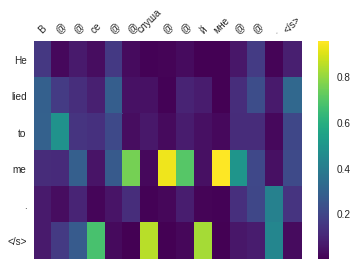

In [0]:
source, result, attentions = greedy_decode(model, "He lied to me.", source_field, target_field)
print(result)
plot_heatmap(source + ['</s>'], result + ['</s>'], attentions)

# Image Captioning with Attention

Attention может работать не только для текстов. Мы вполне можем аттентиться и на картинки:

![](https://cdn-images-1.medium.com/max/2000/0*YCeQbqU6CVxzpave.)  
*From [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044)*

В качестве энкодера будет выступать сверточная сеть. Модель теперь должна научиться генерировать маску внимания на каждом шаге:

![](http://kelvinxu.github.io/projects/diags/model_diag.png =x300)  
*From [http://kelvinxu.github.io/projects/capgen.html](http://kelvinxu.github.io/projects/capgen.html)*

Скачаем данные:

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id': '1qM6fJuaOqhTES17kU_rz9Ydxz540bSJ6'})
downloaded.GetContentFile('image_codes_for_attn.npy')

downloaded = drive.CreateFile({'id': '1O7_3lyTyBMXsBBIt1PwUXwLdkyRQzZML'})
downloaded.GetContentFile('sources.txt')

downloaded = drive.CreateFile({'id': '1t-Dy8TzoRuTMoM7N9NJZKgWXfaw3b6KF'})
downloaded.GetContentFile('texts.txt')

!wget http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/Flickr8k_Dataset.zip
!unzip Flickr8k_Dataset.zip

Скачаем модель сверточной сети (чтобы было)

In [0]:
from torchvision.models.inception import Inception3
from torch.utils.model_zoo import load_url


class BeheadedInception3(Inception3):
    """ Like torchvision.models.inception.Inception3 but the head goes separately """
    
    def forward(self, x):
        x = x.clone()
        x[:, 0] = x[:, 0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
        x[:, 1] = x[:, 1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
        x[:, 2] = x[:, 2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x_for_attn = x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        x_for_capt = x = x.view(x.size(0), -1)
        # 2048
        x = self.fc(x)
        # 1000 (num_classes)
        return x_for_attn, x_for_capt, x
    

inception_model = BeheadedInception3()

inception_url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
inception_model.load_state_dict(load_url(inception_url))

inception_model.eval()

Загрузим данные:

In [0]:
target_field = Field(init_token=BOS_TOKEN, eos_token=EOS_TOKEN)
image_indices_field = Field(sequential=False, use_vocab=False)

fields = [('target', target_field), ('image_index', image_indices_field)]

Чтобы не уткнуться в лимит по памяти - используем memmap формат:

In [0]:
with open('sources.txt') as f_sources:
    image_paths = [line.strip() for line in f_sources]
    
image_tensors = np.memmap('image_codes_for_attn.npy', shape=(8091, 2048, 8, 8), dtype=np.float32)

examples = []
with open('texts.txt') as f_texts:
    for image_ind, texts in enumerate(f_texts):
        for text in texts.split('\t'):
            examples.append(Example.fromlist([target_field.preprocess(text), image_ind], fields))`

In [0]:
dataset = Dataset(examples, fields)

train_dataset, test_dataset = dataset.split(split_ratio=0.85)

print('Train size =', len(train_dataset))
print('Test size =', len(test_dataset))

target_field.build_vocab(train_dataset, min_freq=2)
print('Target vocab size =', len(target_field.vocab))

train_iter, test_iter = BucketIterator.splits(
    datasets=(train_dataset, test_dataset), batch_sizes=(16, 64), shuffle=True, device=DEVICE, sort=False
)

**Задание** Реализуйте почти такие же модели как для перевода, чтобы научиться подписывать картинки:

In [0]:
class AdditiveAttention(nn.Module):
    def __init__(self, query_size, key_size, hidden_dim):
        super().__init__()
        
        self._query_layer = nn.Linear(query_size, hidden_dim)
        self._key_layer = nn.Linear(key_size, hidden_dim)
        self._energy_layer = nn.Linear(hidden_dim, 1)
        
    def forward(self, query, key_proj, value):
        ...

In [0]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, cnn_feature_size, emb_dim=128, rnn_hidden_dim=256, attn_dim=128, num_layers=1):
        super().__init__()

        self._emb = nn.Embedding(vocab_size, emb_dim)
        self._attention = AdditiveAttention(query_size=rnn_hidden_dim, key_size=cnn_feature_size, hidden_dim=attn_dim)
        
        self._cnn_to_h0 = nn.Linear(cnn_feature_size, rnn_hidden_dim)
        self._cnn_to_c0 = nn.Linear(cnn_feature_size, rnn_hidden_dim)
        self._rnn = nn.LSTM(input_size=emb_dim + cnn_feature_size, hidden_size=rnn_hidden_dim, num_layers=num_layers)
        self._out = nn.Linear(rnn_hidden_dim, vocab_size)

    def forward(self, encoder_output, inputs, hidden=None):
        embs = self._emb(inputs)
        
        seq_len, batch_size = inputs.shape[:2]
        
        encoder_output = encoder_output.view(batch_size, encoder_output.shape[1], -1).permute(0, 2, 1)
        
        if hidden is None:
            hidden = self.init_hidden(encoder_output)
        
        outputs, attentions = [], []
        <make forward pass with attention>
    
        return self._out(output), hidden, attentions
    
    def init_hidden(self, encoder_output):
        encoder_output = encoder_output.mean(dim=1)
        h0 = self._cnn_to_h0(encoder_output)
        c0 = self._cnn_to_c0(encoder_output)
        
        return h0.unsqueeze(0), c0.unsqueeze(0)

In [0]:
def do_epoch(model, criterion, data_iter, optimizer=None, name=None):
    epoch_loss = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = len(data_iter)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, batch in enumerate(data_iter):  
                encoder_output = FloatTensor(image_tensors[batch.image_index])
                logits, _, _ = model(encoder_output, batch.target)
                
                target = torch.cat((batch.target[1:], batch.target.new_ones((1, batch.target.shape[1]))))
                loss = criterion(logits.view(-1, logits.shape[-1]), target.view(-1))

                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(), 1.)
                    optimizer.step()

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(name, loss.item(), 
                                                                                         math.exp(loss.item())))
                
            progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(
                name, epoch_loss / batches_count, math.exp(epoch_loss / batches_count))
            )
            progress_bar.refresh()

    return epoch_loss / batches_count


def fit(model, criterion, optimizer, train_iter, epochs_count=1, val_iter=None):
    best_val_loss = None
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss = do_epoch(model, criterion, train_iter, optimizer, name_prefix + 'Train:')
        
        if not val_iter is None:
            val_loss = do_epoch(model, criterion, val_iter, None, name_prefix + '  Val:')

In [0]:
model = Decoder(vocab_size=len(target_field.vocab), cnn_feature_size=image_tensors.shape[1]).to(DEVICE)

pad_idx = target_field.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).to(DEVICE)

optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_iter, epochs_count=30, val_iter=test_iter)

**Задание** Напишите цикл генерации по картинке:

In [0]:
def generate(image_tensor):
    bos_index = target_field.vocab.stoi[BOS_TOKEN]
    eos_index = target_field.vocab.stoi[EOS_TOKEN]

    words, attentions = [], []
    
    model.eval()
    with torch.no_grad():
        ...
        
    return words, attentions

In [0]:
def visualize(image_tensors, image_paths, image_index):
    words, attentions = generate(image_tensors[image_index])

    figure = plt.figure(figsize=(15, 20))

    image_path = image_paths[image_index]
    image = plt.imread('Flicker8k_Dataset/' + image_path)
    image = imresize(image, (299, 299)).astype('float32') / 255.

    for ind, (word, attention) in enumerate(zip(words, attentions)):
        ax = figure.add_subplot(np.ceil(len(words) / 3.), 3, ind + 1)

        ax.text(0, 1, word, color='black', backgroundcolor='white', fontsize=12)
        ax.imshow(image)

        alpha = imresize(1 - attention, (192, 192))

        ax.imshow(alpha, alpha=0.7)

        ax.axis('off')

Визуализируем это!

In [0]:
visualize(test_dataset.examples[0].image_index)

# Дополнительные материалы

## Статьи
Neural Machine Translation by Jointly Learning to Align and Translate, Bahdanau, 2014 [[pdf]](https://arxiv.org/pdf/1409.0473.pdf)  
Effective Approaches to Attention-based Neural Machine Translation, Luong, 2015 [[arxiv]](http://arxiv.org/abs/1508.04025)  
Show, Attend and Tell: Neural Image Caption Generation with Visual Attention, Xu, 2015 [[arxiv]](https://arxiv.org/abs/1502.03044)

## Блоги
[Attention and Augmented Recurrent Neural Networks](https://distill.pub/2016/augmented-rnns/)  
[Deep Learning for NLP Best Practices, Attention](http://ruder.io/deep-learning-nlp-best-practices/index.html#attention)  
[Attention? Attention!](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html)  
[Multi-Modal Methods: Image Captioning (From Translation to Attention)](https://medium.com/mlreview/multi-modal-methods-image-captioning-from-translation-to-attention-895b6444256e)  

## Видео
[Attention в Deep Learning и машинный перевод в очень широком смысле](https://www.youtube.com/watch?v=k63pDjKV3Ew)

# Сдача

[Форма для сдачи](https://goo.gl/forms/RnQN6UrGKdxPxPBG3)  
[Feedback](https://goo.gl/forms/9aizSzOUrx7EvGlG3)